In [203]:
##########################################
# Fama French 3 Factors                  #
# Qingyi (Freda) Song Drechsler          #
# Date: April 2018                       #
# Updated: June 2020                     #
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
#import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats

In [204]:
###################
# Connect to WRDS #
###################
conn=wrds.Connection()

Loading library list...
Done


In [205]:
###################
# Compustat Block #
###################
comp = conn.raw_sql("""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1925'
                    """, date_cols=['datadate'])

comp['year']=comp['datadate'].dt.year

In [206]:
# create preferrerd stock
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])
comp['txditc']=comp['txditc'].fillna(0)

In [207]:
# create book equity
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan)

In [208]:
# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

comp=comp[['gvkey','datadate','year','be','count']]

In [209]:
comp

,gvkey,datadate,year,be,count
0,001000,1961-12-31,1961,NaN,0
1,001000,1962-12-31,1962,NaN,1
2,001000,1963-12-31,1963,0.561,2
3,001000,1964-12-31,1964,0.627,3
4,001000,1965-12-31,1965,0.491,4
...,...,...,...,...,...
68889,353945,2021-12-31,2021,305.149,0
68890,353945,2022-12-31,2022,316.595,1
68891,354003,2023-12-31,2023,NaN,0
68892,356128,2022-12-31,2022,1778.026,0


In [210]:
###################
# CRSP Block      #
###################
# sql similar to crspmerge macro
crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1924' and '12/31/2023'
                      and b.exchcd between 1 and 3
                      """, date_cols=['date']) 

# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

In [211]:
# add delisting return
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """, date_cols=['dlstdt'])

dlret.permno=dlret.permno.astype(int)
#dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)

# retadj factors in the delisting returns
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1

# calculate market equity
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
crsp=crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])

In [212]:
### Aggregate Market Cap ###
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()

# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()

# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])

# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])

# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()


In [213]:
# keep December market cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

### July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])

In [214]:
# cumret by stock
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()

# lag cumret
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

In [215]:
# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()

In [216]:
#######################
# CCM Block           #
#######################
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

In [217]:
# set link date bounds
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

In [218]:
ccm2

,gvkey,permno,datadate,yearend,jdate,be,count
9,001000,25881.0,1970-12-31,1970-12-31,1971-06-30,10.544,9
10,001000,25881.0,1971-12-31,1971-12-31,1972-06-30,8.382,10
11,001000,25881.0,1972-12-31,1972-12-31,1973-06-30,7.309,11
12,001000,25881.0,1973-12-31,1973-12-31,1974-06-30,8.798,12
13,001000,25881.0,1974-12-31,1974-12-31,1975-06-30,8.279,13
...,...,...,...,...,...,...,...
679076,350681,22205.0,2021-12-31,2021-12-31,2022-06-30,596.490,1
679079,351038,16161.0,2021-12-31,2021-12-31,2022-06-30,0.657,2
679080,351038,16161.0,2022-12-31,2022-12-31,2023-06-30,7.407,3
679090,352262,23773.0,2022-12-31,2022-12-31,2023-06-30,646.557,0


In [219]:
historical_ff_data = pd.read_csv("DFF_BE_With_Nonindust_Cleaned.csv")
historical_ff_data = historical_ff_data.drop('Unnamed: 0', axis = 1)
historical_ff_data['datadate'] = pd.to_datetime(historical_ff_data['datadate'])
historical_ff_data['yearend'] = pd.to_datetime(historical_ff_data['yearend'])
historical_ff_data['jdate'] = pd.to_datetime(historical_ff_data['jdate'])
historical_ff_data

,permno,datadate,yearend,jdate,be,count
0,10006,1926-12-31,1926-12-31,1927-06-30,67.743,0
1,10006,1927-12-31,1927-12-31,1928-06-30,71.245,1
2,10006,1928-12-31,1928-12-31,1929-06-30,70.139,2
3,10006,1929-12-31,1929-12-31,1930-06-30,70.139,3
4,10006,1930-12-31,1930-12-31,1931-06-30,70.139,4
...,...,...,...,...,...,...
29807,86239,1973-12-31,1973-12-31,1974-06-30,165.883,36
29808,86239,1974-12-31,1974-12-31,1975-06-30,168.391,37
29809,86861,1998-12-31,1998-12-31,1999-06-30,426.523,0
29810,92567,1989-12-31,1989-12-31,1990-06-30,941.791,0


In [260]:
unique_permno = list(ccm2['permno'].unique())
permno_gvkey = {}
for i in range(0, len(unique_permno)):
    temp = ccm2.loc[ccm2['permno'] == unique_permno[i], 'gvkey']
    if not temp.empty:
        gvkey = temp.iloc[0]
        permno_gvkey[unique_permno[i]] = gvkey
np.save('permno_gvkey_dictionary.npy', permno_gvkey)

In [258]:
historical_ff_data_with_gvkey = pd.read_csv("DFF_BE_With_Nonindust_Cleaned_with_gvkey.csv")
historical_ff_data_with_gvkey = historical_ff_data_with_gvkey.drop('Unnamed: 0', axis = 1)
historical_ff_data_with_gvkey['datadate'] = pd.to_datetime(historical_ff_data_with_gvkey['datadate'])
historical_ff_data_with_gvkey['yearend'] = pd.to_datetime(historical_ff_data_with_gvkey['yearend'])
historical_ff_data_with_gvkey['jdate'] = pd.to_datetime(historical_ff_data_with_gvkey['jdate'])

In [257]:
ccm2_merged = pd.concat([historical_ff_data_with_gvkey, ccm2], ignore_index=True, axis=0)
#ccm2_merged.be_x.fillna(ccm2_merged.be_y, inplace=True)
#ccm2_merged = ccm2_merged.drop(['be_y', 'count_y'], axis = 1)
#ccm2_merged = ccm2_merged.rename({'be_x': 'be', 'count_x': 'count'}, axis='columns')
ccm2_merged = ccm2_merged.sort_values(by=['permno','jdate']).drop_duplicates()

In [223]:
# link comp and crsp
ccm_jun=pd.merge(crsp_jun, ccm2_merged, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']

In [224]:
# select NYSE stocks for bucket breakdown
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & \
             (ccm_jun['count']>=1) & ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]

# size breakdown
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})

# beme breakdown
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])

# join back size and beme breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])

/usr/local/sas/jupyterhub/prod/venvs/20240104/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/sas/jupyterhub/prod/venvs/20240104/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/sas/jupyterhub/prod/venvs/20240104/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/sas/jupyterhub/prod/venvs/20240104/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/sas/jupyterhub/prod/venvs/20240104/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - valu

In [226]:
# function to assign sz and bm bucket
def sz_bucket(row):
    if row['me']==np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value


In [227]:
# assign size portfolio
ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')

# assign book-to-market portfolio
ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')

# create positivebmeme and nonmissport variable
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)

In [228]:
# store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year

# merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
        june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0)& (ccm3['posbm']==1) & (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

ccm5=ccm3[(ccm3['wt']>0) &
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

/tmp/18881898.1.jupyterhub.q/ipykernel_37959/3796395223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june['ffyear']=june['jdate'].dt.year


In [255]:
stdev_monthly_returns = ccm5.groupby('date')['retadj'].std()

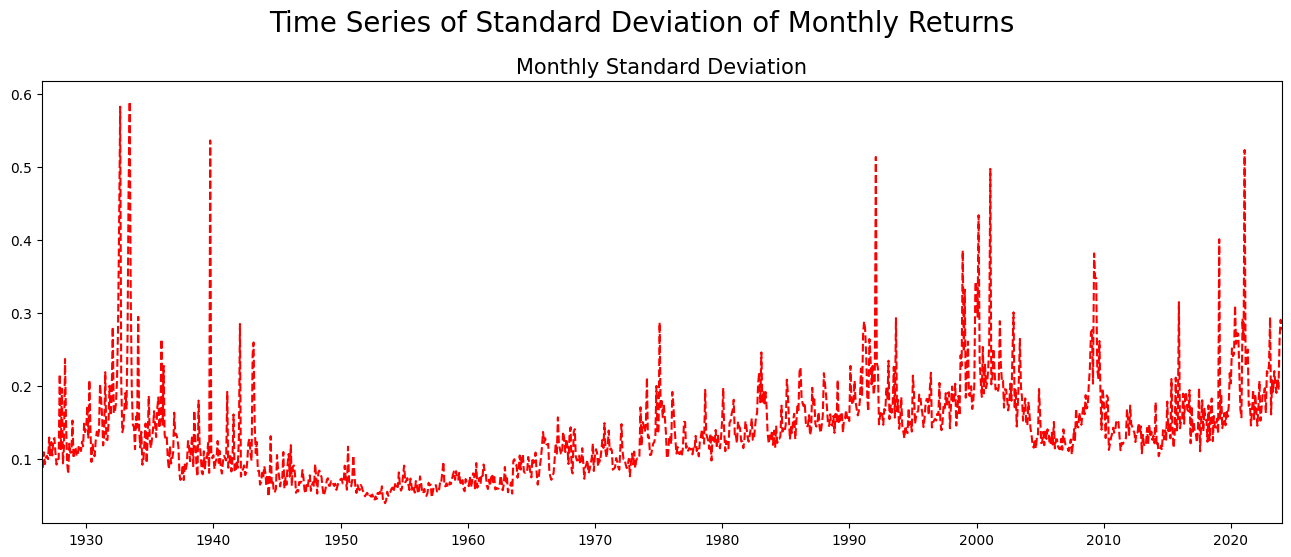

In [254]:
plt.figure(figsize=(16,12))
plt.suptitle('Time Series of Standard Deviation of Monthly Returns', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Monthly Standard Deviation', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])
ax1.plot(stdev_monthly_returns, 'r--')

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [236]:
ccm5.sort_values(by = 'jdate')

,date,permno,shrcd,exchcd,retadj,me,wt,cumretx,ffyear,jdate,szport,bmport,posbm,nonmissport,weighted_returns
515489,1926-07-31,13995,10,1,-0.045977,4.980000e+03,5.220000e+03,0.954023,1926,1926-07-31,NaN,NaN,NaN,NaN,-1.908046e+01
241908,1926-07-31,11551,10,1,0.000000,4.625000e+03,4.625000e+03,1.000000,1926,1926-07-31,NaN,NaN,NaN,NaN,0.000000e+00
1499134,1926-07-31,28513,10,1,0.069079,1.657500e+04,1.550400e+04,1.069079,1926,1926-07-31,NaN,NaN,NaN,NaN,9.541537e+01
511112,1926-07-31,13952,10,1,0.059361,9.541000e+03,9.006375e+03,1.059361,1926,1926-07-31,NaN,NaN,NaN,NaN,4.719694e+01
89273,1926-07-31,10540,10,1,0.000000,0.000000e+00,6.500250e+03,NaN,1926,1926-07-31,NaN,NaN,NaN,NaN,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691098,2023-12-29,82779,11,3,-0.127273,5.701920e+05,5.186940e+05,0.646029,2023,2023-12-31,,,0.0,0.0,-6.047504e+03
743939,2023-12-29,16505,11,3,0.120613,5.921679e+06,5.320555e+06,1.356081,2023,2023-12-31,B,H,1.0,1.0,5.951929e+04
2672547,2023-12-29,66325,11,3,0.279441,4.326302e+06,3.398002e+06,1.171571,2023,2023-12-31,B,M,1.0,1.0,1.007455e+05
743317,2023-12-29,16499,11,1,0.094403,3.212755e+06,3.197795e+06,1.193449,2023,2023-12-31,S,H,1.0,1.0,2.527448e+04


In [238]:
############################
# Form Fama French Factors #
############################

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [239]:

# value-weigthed return
vwret=ccm5.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['sbport']=vwret['szport']+vwret['bmport']

# firm count
vwret_n=ccm5.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['sbport']=vwret_n['szport']+vwret_n['bmport']

# tranpose
ff_factors=vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms=vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()


In [240]:
# create SMB and HML factors
ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2
ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

ff_factors['WB']=(ff_factors['BL']+ff_factors['BM']+ff_factors['BH'])/3
ff_factors['WS']=(ff_factors['SL']+ff_factors['SM']+ff_factors['SH'])/3
ff_factors['WSMB'] = ff_factors['WS']-ff_factors['WB']
ff_factors=ff_factors.rename(columns={'jdate':'date'})

# n firm count
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

ff_nfirms['B']=ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']
ff_nfirms['S']=ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']
ff_nfirms['SMB']=ff_nfirms['B']+ff_nfirms['S']
ff_nfirms['TOTAL']=ff_nfirms['SMB']
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})

In [241]:
###################
# Compare With FF #
###################
_ff = conn.get_table(library='ff', table='factors_monthly')
_ff=_ff[['date','smb','hml']]
_ff['date']=_ff['date']+MonthEnd(0)

# Convert 'date' column in _ff DataFrame to datetime
#_ff['date'] = pd.to_datetime(_ff['date']) + MonthEnd(0)

# Filter ff_factors to include only dates that are present in _ff
ff_factors_filtered = ff_factors[ff_factors['date'].isin(_ff['date'])]

# Set 'date' column as index for both DataFrames
_ff.set_index('date', inplace=True)
ff_factors_filtered.set_index('date', inplace=True)

# Concatenate the DataFrames along the columns axis
_ffcomp = pd.concat([_ff, ff_factors_filtered[['WSMB', 'WHML']]], axis=1, join='inner')

# Reset index to make 'date' a column again
_ffcomp.reset_index(inplace=True)

# Filter dates
_ffcomp70 = _ffcomp[_ffcomp['date'] >= pd.Timestamp('1970-01-01')]

# Convert Decimal objects to floats
_ffcomp70['hml'] = _ffcomp70['hml'].astype(float)
_ffcomp70['WHML'] = _ffcomp70['WHML'].astype(float)

# Replace infinite values with a large finite value
_ffcomp70.replace([np.inf, -np.inf], np.nan, inplace=True)
_ffcomp70.fillna(1e15, inplace=True)  # Replace with a large finite value

# Calculate Pearson correlation coefficient
correlation_coefficient, p_value = stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML'])
print("Pearson correlation coefficient:", correlation_coefficient)
print("P-value:", p_value)

Pearson correlation coefficient: 0.9843247399823011
P-value: 0.0


/tmp/18881898.1.jupyterhub.q/ipykernel_37959/265363642.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _ffcomp70['hml'] = _ffcomp70['hml'].astype(float)
/tmp/18881898.1.jupyterhub.q/ipykernel_37959/265363642.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _ffcomp70['WHML'] = _ffcomp70['WHML'].astype(float)
/tmp/18881898.1.jupyterhub.q/ipykernel_37959/265363642.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

In [242]:
_ffcomp.head(2)

,date,smb,hml,WSMB,WHML
0,1927-07-31,-0.032500,-0.011400,NaN,NaN
1,1927-08-31,-0.006900,-0.037400,NaN,NaN


In [243]:
_ffcomp.dtypes

date    datetime64[ns]
smb             object
hml             object
WSMB           float64
WHML           float64
dtype: object

In [244]:
_ffcomp.tail(2)

,date,smb,hml,WSMB,WHML
1156,2023-11-30,-0.000200,0.016400,0.002062,-0.000339
1157,2023-12-31,0.063400,0.049300,0.072919,0.026597


In [245]:
_ffcomp.date = pd.to_datetime(_ffcomp.date)
_ffcomp.set_index('date', inplace=True)
_ffcomp.head(2)

,smb,hml,WSMB,WHML
date,,,,
1927-07-31,-0.032500,-0.011400,NaN,NaN
1927-08-31,-0.006900,-0.037400,NaN,NaN


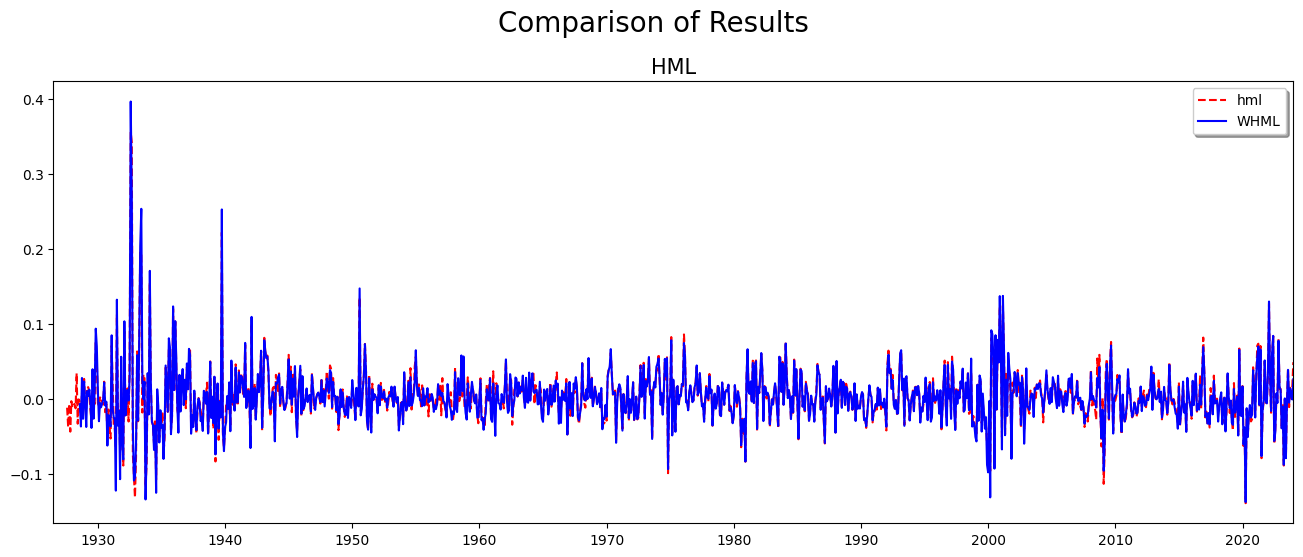

In [246]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Results', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('HML', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp['hml'], 'r--', _ffcomp['WHML'], 'b-')
ax1.legend(('hml','WHML'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [247]:
_ffcomp["WHML"] = _ffcomp["WHML"].fillna(0)

In [248]:
_ffcomp["Cum_hml"] = np.cumprod(1 + _ffcomp['hml'].values) - 1
_ffcomp["Cum_WHML"] = np.cumprod(1 + _ffcomp['WHML'].values) - 1
_ffcomp

,smb,hml,WSMB,WHML,Cum_hml,Cum_WHML
date,,,,,,
1927-07-31,-0.032500,-0.011400,NaN,0.000000,-0.011400,0.000000
1927-08-31,-0.006900,-0.037400,NaN,0.000000,-0.048373640000,0.000000
1927-09-30,-0.036300,-0.006300,NaN,0.000000,-0.054368886068000000,0.000000
1927-10-31,0.021200,-0.043300,NaN,0.000000,-0.095314713301255600000000,0.000000
1927-11-30,0.027200,-0.002700,NaN,0.000000,-0.0977573635753422098800000000,0.000000
...,...,...,...,...,...,...
2023-08-31,-0.031600,-0.010600,-0.036932,-0.004600,22.85366227258989715024438317,19.226367
2023-09-30,-0.025100,0.015200,-0.025090,0.014037,23.21623793913326358692809779,19.510294
2023-10-31,-0.038700,0.001900,-0.044537,0.004957,23.26224879121761678774326118,19.611973


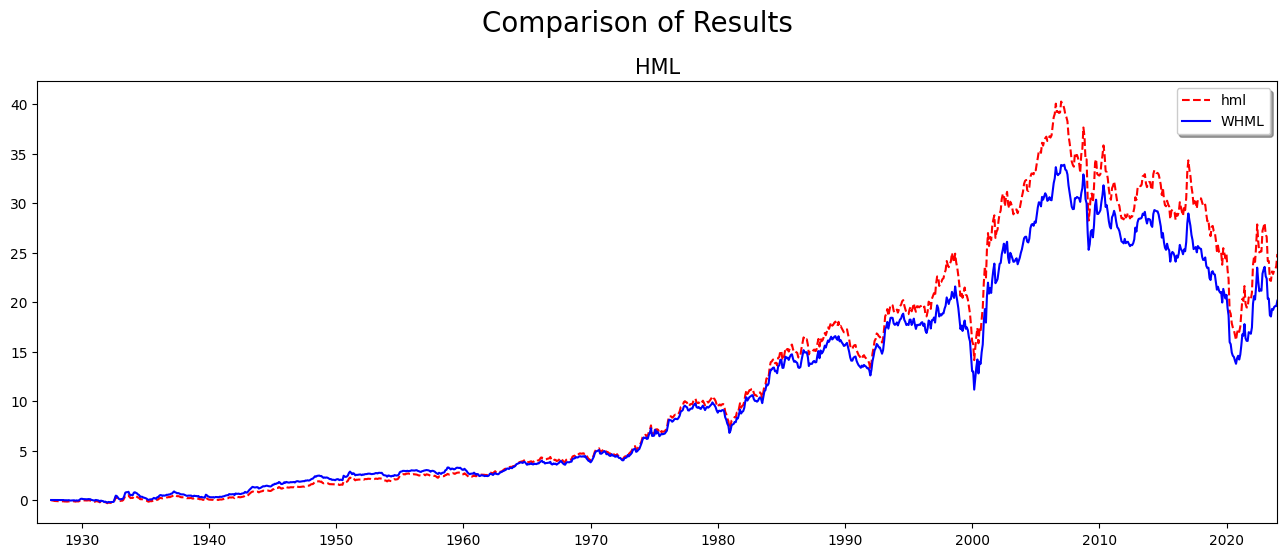

In [249]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Results', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('HML', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp['Cum_hml'], 'r--', _ffcomp['Cum_WHML'], 'b-')
ax1.legend(('hml','WHML'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()